# Get and explore dataset

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re
import seaborn as sns

In [2]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [3]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [4]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [5]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [6]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

The mean number of words in a review is 4.34
The standard deviation of words in a review is 2.17


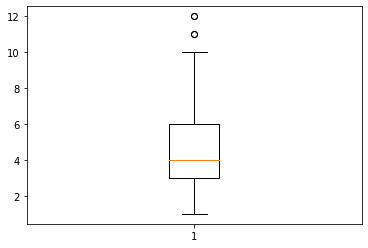

There are 2559 unique words in the dataset
There are 1793 reviews in the dataset


In [9]:
import statistics as stats

lengths =[]
for review in data:
    num_words = review.split()
    lengths.append(len(num_words))

mean = stats.mean(lengths)
deviation = stats.stdev(lengths)
print(f"The mean number of words in a review is {round(mean, 2)}")
print(f"The standard deviation of words in a review is {round(deviation, 2)}")
plt.boxplot(x=lengths)
plt.show()
# - Calculate the number of unique words in the dataset
every_word = ' '.join(data)
words = every_word.split()
unique = len(set(words))
print(f"There are {unique} unique words in the dataset")

# - Perform any other dataset investigation that you feel would be valuable
print(f"There are {len(data)} reviews in the dataset")

In [10]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


The tokenization process appears to be incorrect, as not every word is tokenized. For example, in the third review "beautiful", the tokenized data is empty, and so clearly a positive review is being passed to the model with no label. The second review, "the medicine of the future", appears with tokenized data of "[2, 4, 2]", which refers to the words "[the, of, the]". This will clearly affect ML model's accuracy.

# Pre-processing

In [12]:
# Pre-processing
# Write some code to pre-process the data so that each review is the same length
from keras_preprocessing.sequence import pad_sequences
maxlen=4
padded_data = pad_sequences(tokenized_data, maxlen=maxlen)

print(padded_data[0:5])

[[18  4  2 19]
 [ 0  2  4  2]
 [ 0  0  0  0]
 [ 0  0  6  4]
 [ 0  1 12  3]]


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, test_size=0.2, random_state=42)

print(X_train[0:5])
print(y_train[0:5])

[[ 0 23  2  4]
 [ 0  0  4 11]
 [ 0  2  8  6]
 [ 0  0  0  1]
 [ 0  7  9  3]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [14]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Fill in the following function so it
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(model, X_test, y_test):      
    #To do
    # Convert test sets to classifiers
    testX = to_class(X_test)
    testY = to_class(y_test)
    testPredict = to_class(model.predict(X_test))
    # Precision score
    precision = precision_score(testY, testPredict)
    print("Precision Score: %.2f" % (precision))
    # Recall Score
    recall = recall_score(testY, testPredict)
    print("Recall Score: %.2f" % (recall))
    f1 = f1_score(testY, testPredict)
    # F1 Score
    print("F1 Score: %.2f" % (f1))
    # Confusion Matrix
    print("Confusion matrix:")
    print(confusion_matrix(testY, testPredict))

# Build and tune model

Define network architecture

In [15]:
# Import model dependecies
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, BatchNormalization
from keras.models import Sequential

# Specify parameters for embedding layer
input_dim = unique
output_dim = 10
input_length = 4

# Initialize model
model = Sequential()

model.add(Embedding(input_dim, output_dim, input_length=input_length))
model.add(SpatialDropout1D(0.2))

model.add(BatchNormalization())
model.add(LSTM(32, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

Train model

In [16]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Specify parameter for model fitting
n_epochs = 5
batch_size = 10

# Fit model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=2)

Epoch 1/5
144/144 - 2s - loss: 0.6912 - accuracy: 0.5251 - 2s/epoch - 17ms/step
Epoch 2/5
144/144 - 0s - loss: 0.6788 - accuracy: 0.5760 - 375ms/epoch - 3ms/step
Epoch 3/5
144/144 - 0s - loss: 0.6725 - accuracy: 0.5865 - 292ms/epoch - 2ms/step
Epoch 4/5
144/144 - 0s - loss: 0.6673 - accuracy: 0.5837 - 385ms/epoch - 3ms/step
Epoch 5/5
144/144 - 0s - loss: 0.6620 - accuracy: 0.5927 - 308ms/epoch - 2ms/step


Examine performance of model

In [17]:
# Assess model
assess_model(model, X_test, y_test)

12/12 [==============================] - 0s 2ms/step
Precision Score: 0.59
Recall Score: 0.69
F1 Score: 0.64
Confusion matrix:
[[ 90  86]
 [ 57 126]]


Plot graphs for accuracy and loss

In [18]:
def plot_loss_acc(history, output_dim):
    """
    This function plots the accuracy and loss of a model over the number of epochs
    """
    fig = plt.figure(figsize=(12, 2))
    fig.suptitle(f'Loss and Accuracy for output dimension {output_dim}')
    
    # plot loss
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'])
    ax.grid(True)
    ax.set(xlabel='iterations', title='Loss')
    
    #plot accuracy
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'])
    ax.grid(True)
    ax.set(xlabel='iterations', title='Accuracy');

    plt.show()

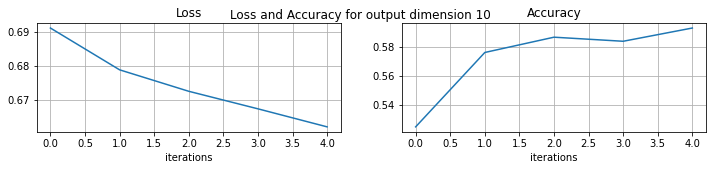

In [19]:
plot_loss_acc(history, 10)

# Make a prediction

In [20]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = pad_sequences(tokenized, padding='post', maxlen=maxlen)

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.






In [21]:
pred = model.predict(padded)
to_word_label(pred)

1/1 [==============================] - 0s 24ms/step


['negative', 'negative', 'negative', 'negative', 'negative']

The results of the prediction are not normal or accurate, as the prediction has returned negative for the model. This prediction is clearly incorrect as there are 2 positive reviews in the dataset.

There could be an error with the dataset, or this may be attributed to the short number of epochs during model training.

Another reason could be that tokenization of words appears partially incorrect as described earlier.